# Practica 4: Extraccion de Datos (PLN)

Autor: Jorge Marcos Martos

In [1]:
import nltk
import re
from nltk.corpus import cess_esp

## 1. Creacion del Corpus y Entrenamiento de Tagger en Español

Creamos varios corpus para ver como nuestras funciones se comportan en diferentes casos, para tal proposito creamos ``document`` que contiene pedidos con ingredientes, ``document1`` que solo contiene un pedido y ademas sin especificar ingredientes, y ``document3`` el cual combina pedidos con ingredientes y uno sin ingredientes.

In [2]:
document = "Hola, buenas tardes, quisiera un bocadillo de jamon y queso. Necesitamos 20 tartas de vainilla, ahora, es que tenemos cumpleaños hoy. Hola, si, quisieramos 8 shawarmas de pollo para esta noche. Hoy me pasare por el restaurante, tenedme listo los 2 bocadillos de tortilla que pido siempre, gracias. Hola, quisiera pedir 5 perritos calientes con mostaza para esta noche. Seria posible encargar 20 tartas de chocolate hoy?"
document1 = 'Hola, quiero un perrito caliente y ya está'
document3 = document + ' ' + document1

Importamos el corpus CESS del español, que es una colección de textos anotados

In [3]:
sents = cess_esp.tagged_sents()
# comprobamos la carga y la comentamos para que no repercuta en el remdimiento
print (sents) 

[[('El', 'da0ms0'), ('grupo', 'ncms000'), ('estatal', 'aq0cs0'), ('Electricité_de_France', 'np00000'), ('-Fpa-', 'Fpa'), ('EDF', 'np00000'), ('-Fpt-', 'Fpt'), ('anunció', 'vmis3s0'), ('hoy', 'rg'), (',', 'Fc'), ('jueves', 'W'), (',', 'Fc'), ('la', 'da0fs0'), ('compra', 'ncfs000'), ('del', 'spcms'), ('51_por_ciento', 'Zp'), ('de', 'sps00'), ('la', 'da0fs0'), ('empresa', 'ncfs000'), ('mexicana', 'aq0fs0'), ('Electricidad_Águila_de_Altamira', 'np00000'), ('-Fpa-', 'Fpa'), ('EAA', 'np00000'), ('-Fpt-', 'Fpt'), (',', 'Fc'), ('creada', 'aq0fsp'), ('por', 'sps00'), ('el', 'da0ms0'), ('japonés', 'aq0ms0'), ('Mitsubishi_Corporation', 'np00000'), ('para', 'sps00'), ('poner_en_marcha', 'vmn0000'), ('una', 'di0fs0'), ('central', 'ncfs000'), ('de', 'sps00'), ('gas', 'ncms000'), ('de', 'sps00'), ('495', 'Z'), ('megavatios', 'ncmp000'), ('.', 'Fp')], [('Una', 'di0fs0'), ('portavoz', 'nccs000'), ('de', 'sps00'), ('EDF', 'np00000'), ('explicó', 'vmis3s0'), ('a', 'sps00'), ('EFE', 'np00000'), ('que', 'c

Creamos un conjunto de entrenamiento y otro de prueba

In [4]:
training = []
test = []
for i in range(len(sents)):
    if i % 10:
        training.append(sents[i])
    else:
        test.append(sents[i])

#Comprobemos el tamano de cada uno de los set creados
print(len(training)) 
print(len(test))

5427
603


Creamos un analizador morfologico usando el ``HiddenMarkovModelTagger`` de la libreria ``nltk`` que es el que mejor resultado da:

In [5]:
from nltk.tag.hmm import HiddenMarkovModelTagger

hmm_tagger = HiddenMarkovModelTagger.train(training)

print ('Acierto con HMMs:', hmm_tagger.evaluate(test)*100)

Acierto con HMMs: 89.88905831011094


## 2. Procesamiento de Pedidos

Primero creamos una gramatica chunk que nos permita identificar la parte del pedido que se refiere a la comida, dividiendo el pedido entre 'Cantidad', 'Comida' e 'Ingredientes'. Esta gramatica chunk tendra en cuenta los taggs entrenados anteriormente usando el corpus CESS en espanol.

Una vez tengamos la gramatica chunk podremos crear nuestro propio parser, que ademas de parsear sera capaz de identificar cantidades, comidas e ingredientes.

In [8]:
# Gramatica del chunk que nos permitira separar la informacion en cantidades, comidas e ingredientes
chunk_grammar = chunk_grammar = """Comida: {<Z|di.*>+<nc.*>+<aq.*>?}
                }<Z|di.*>+{
                Cantidad: {<Z|di.*>+}
                Ingredientes: {<sp.*><n.*><cc>?<n.*>?}
                }<sp.*>+<cc>?{""" 
    
# Creamos el parser usando nuestra gramatica chunk y el RegexpParser del nltk
regex_parser = nltk.RegexpParser(chunk_grammar)

Ahora crearemos diferentes funciones para el procesamiento de los pedidos.

In [9]:
from nltk import Tree

def conversion(tree):
    '''Esta funcion es capaz de extraer diccionarios de un arbol resultante de un texto parseado'''
    dlist = [] # Lista que incluira los diccionarios
    d = dict() # Diccionarios creados con las categorias creadas con nuestra gramatica chunk
    for item in tree:
        if isinstance(item, Tree): # Si tenemos un arbol creamos un diccionario que contenga las hojas
            d[item.label()] = ' '.join([l[0] for l in item.leaves()])
        else:
            dlist.append(d) if len(d)>0 else None # Cuando acabamos devolvemos el diccionario
            d = dict()
    dlist.append(d) if len(d)>0 else None # anadimos los diccionarios en la lista hasta el final
    return dlist

In [113]:
def process_order(document, parser):
    '''Esta funcion acepta un parseador predefinido y una cadena, para despues procesarla, dividiendo la cadena 
    en diferentes pedidos y clasificar las partes de cada pedido para sacar cantidades, comidas e ingredientes'''
        
    # Parseamos nuestro texto usando nuestro regex_parser
    parsed_text = [parser.parse(hmm_tagger.tag(nltk.word_tokenize(sent))) for sent in nltk.sent_tokenize(document)]

    
    # Este bucle for introduce los diccionarios en una lista
    info = []
    for tree in parsed_text:
        info.append(conversion(tree)) 
        
    # Este bucle for une los diccionario de comida y cantidad con el de ingredientes, y desecha el duplicado ingredientes
    for i in range(len(info)):
    # Los ingredientes aparecen en una diccionario diferente por lo que este 'if' maneja la excepcion de que no haya ingredientes
        if len(info[i]) > 1:
            info[i][0].update(info[i][1])
            info[i].pop()
        
    # Este bucle for desempaqueta los diccionarios de dentro de las listas.    
    list_dictionaries = []
    for i in range(len(info)):
        # Desempaquetamos el diccionario
        list_dictionaries.append(info[i][0])
    return list_dictionaries

Comprobemos si funciona en todos los casos:

In [88]:
process_order(document1, regex_parser)

[{'Cantidad': 'un', 'Comida': 'perrito caliente'}]

In [89]:
process_order(document3, regex_parser)

[{'Cantidad': 'un', 'Comida': 'bocadillo', 'Ingredientes': 'jamon y queso'},
 {'Cantidad': '20', 'Comida': 'tartas', 'Ingredientes': 'vainilla'},
 {'Cantidad': '8', 'Comida': 'shawarmas', 'Ingredientes': 'pollo'},
 {'Cantidad': '2', 'Comida': 'bocadillos', 'Ingredientes': 'tortilla'},
 {'Cantidad': '5', 'Comida': 'perritos calientes', 'Ingredientes': 'mostaza'},
 {'Cantidad': '20', 'Comida': 'tartas', 'Ingredientes': 'chocolate'},
 {'Cantidad': 'un', 'Comida': 'perrito caliente'}]

In [90]:
def process_iob_tags(document, parser):
    '''Esta funcion acepta un parseador predefinido y una cadena, para despues procesarla, dividiendo 
    la cadena en diferentes pedidos y clasificar las partes de cada pedido usando etiquetas iob'''
        
    # Parseamos nuestro texto usando nuestro regex_parser
    parsed_text = [parser.parse(hmm_tagger.tag(nltk.word_tokenize(sent))) for sent in nltk.sent_tokenize(document)]

    
    # Este bucle for introduce los diccionarios en una lista
    for parsed_sent in parsed_text:
        list_of_lists = []
        for i in range(len(parsed_text)):
            # Filtramos el arbol padre S
            for j in parsed_text[i].subtrees(filter = lambda x: x.label() == 'S'):
                # Obtenemos las etiquetas
                iob_tags = nltk.tree2conlltags(j)
    
                words_tagged = []
    
                for iob in iob_tags: 
                    words_tagged.append(iob)
            list_of_lists.append(words_tagged)
            
    if len([sent for sent in nltk.sent_tokenize(document)]) == 1:
        return list_of_lists[0]
    return list_of_lists

In [91]:
process_iob_tags(document1, regex_parser)

[('Hola', 'np0000p', 'O'),
 (',', 'Fc', 'O'),
 ('quiero', 'vmis3s0', 'O'),
 ('un', 'di0ms0', 'B-Cantidad'),
 ('perrito', 'ncms000', 'B-Comida'),
 ('caliente', 'aq0cs0', 'I-Comida'),
 ('y', 'cc', 'O'),
 ('ya', 'rg', 'O'),
 ('está', 'vmip3s0', 'O')]

In [92]:
process_iob_tags(document3, regex_parser)

[[('Hola', 'np0000p', 'O'),
  (',', 'Fc', 'O'),
  ('buenas', 'aq0fp0', 'O'),
  ('tardes', 'ncfp000', 'O'),
  (',', 'Fc', 'O'),
  ('quisiera', 'vmis3s0', 'O'),
  ('un', 'di0ms0', 'B-Cantidad'),
  ('bocadillo', 'ncms000', 'B-Comida'),
  ('de', 'sps00', 'O'),
  ('jamon', 'np0000l', 'B-Ingredientes'),
  ('y', 'cc', 'I-Ingredientes'),
  ('queso', 'np0000p', 'I-Ingredientes'),
  ('.', 'Fp', 'O')],
 [('Necesitamos', 'da0mp0', 'O'),
  ('20', 'Z', 'B-Cantidad'),
  ('tartas', 'ncmp000', 'B-Comida'),
  ('de', 'sps00', 'O'),
  ('vainilla', 'np0000l', 'B-Ingredientes'),
  (',', 'Fc', 'O'),
  ('ahora', 'rg', 'O'),
  (',', 'Fc', 'O'),
  ('es', 'vsip3s0', 'O'),
  ('que', 'cs', 'O'),
  ('tenemos', 'sn.e-SUJ', 'O'),
  ('cumpleaños', 'vmis3s0', 'O'),
  ('hoy', 'rg', 'O'),
  ('.', 'Fp', 'O')],
 [('Hola', 'np0000p', 'O'),
  (',', 'Fc', 'O'),
  ('si', 'cs', 'O'),
  (',', 'Fc', 'O'),
  ('quisieramos', 'sps00', 'O'),
  ('8', 'Z', 'B-Cantidad'),
  ('shawarmas', 'ncmp000', 'B-Comida'),
  ('de', 'sps00', 'O'),
 

In [116]:
def create_trees(document, parser):
    '''Esta funcion crea arboles parseados para su posterior analisis, la funcion acepta una cadena que dividira
    en diferentes pedidos, ademas de un parseador predefinido'''
    sentences = [sent for sent in nltk.sent_tokenize(document)]

    chunks = []

    for sentence in sentences:
        sentence_tokens = nltk.word_tokenize(sentence)
        tagged_sentence = hmm_tagger.tag(sentence_tokens)
        tree = parser.parse(tagged_sentence)
        # añadimos el árbol directamente ya que los taggers entrenan con árboles con los chunks etiquetados
        chunks.append(tree)
    if len([sent for sent in nltk.sent_tokenize(document)]) == 1:
        # Hacemos que devuelva el arbol directamente si se trata solo de un pedido
        return chunks[0]
    return chunks

In [94]:
create_trees(document3, regex_parser)

[Tree('S', [('Hola', 'np0000p'), (',', 'Fc'), ('buenas', 'aq0fp0'), ('tardes', 'ncfp000'), (',', 'Fc'), ('quisiera', 'vmis3s0'), Tree('Cantidad', [('un', 'di0ms0')]), Tree('Comida', [('bocadillo', 'ncms000')]), ('de', 'sps00'), Tree('Ingredientes', [('jamon', 'np0000l'), ('y', 'cc'), ('queso', 'np0000p')]), ('.', 'Fp')]),
 Tree('S', [('Necesitamos', 'da0mp0'), Tree('Cantidad', [('20', 'Z')]), Tree('Comida', [('tartas', 'ncmp000')]), ('de', 'sps00'), Tree('Ingredientes', [('vainilla', 'np0000l')]), (',', 'Fc'), ('ahora', 'rg'), (',', 'Fc'), ('es', 'vsip3s0'), ('que', 'cs'), ('tenemos', 'sn.e-SUJ'), ('cumpleaños', 'vmis3s0'), ('hoy', 'rg'), ('.', 'Fp')]),
 Tree('S', [('Hola', 'np0000p'), (',', 'Fc'), ('si', 'cs'), (',', 'Fc'), ('quisieramos', 'sps00'), Tree('Cantidad', [('8', 'Z')]), Tree('Comida', [('shawarmas', 'ncmp000')]), ('de', 'sps00'), Tree('Ingredientes', [('pollo', 'ncms000')]), ('para', 'sps00'), ('esta', 'dd0fs0'), ('noche', 'ncfs000'), ('.', 'Fp')]),
 Tree('S', [('Hoy', 'rg'

Comprobemos como funciona:

In [95]:
trees = create_trees(document3, regex_parser)

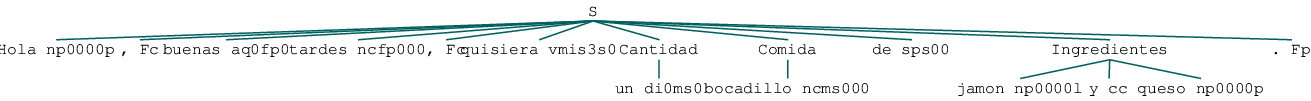

In [96]:
trees[0]

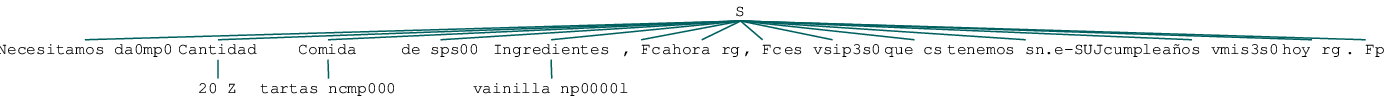

In [97]:
trees[1]

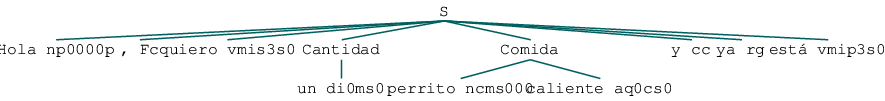

In [20]:
trees[6]

## 3. Entrenamiento de Modelos para la Extraccion de Datos.

A continuacion crearemos un corpus de entrenamiento y otro de test para asi poder dilucidar que algoritmo es el que mejor nos funciona para extraer informacion de los pedidos.

El *IOB Accuracy* nos da cuantos de los tokens han sido correctamente asignados, mientras que *Precision* nos da cuantos de los chunks han sido correctamente asignados en referencia a esos tokens. 

El criterio para la seleccion del modelo deberia ser aquel modelo que presente valores altos tanto en *IOB Accuracy* como en *Precision*.

In [21]:
training_corpus = document3
test_corpus = "Hola, quisiera 3 paellas de marisco, llegaremos a la tarde. Que tal todo? Vamos a comer hoy alli, tened preparadas 5 fideuas. Hoy venimos con hambre, tened preparadas 9 crepes con chocolate y nata. Quiero 3 cervezas de trigo. Dame 3 risottos de setas. 2 ensaladas de pasta mas"

In [98]:
parsed_training_corpus = create_trees(training_corpus, regex_parser)
parsed_test_corpus = create_trees(test_corpus, regex_parser)

### 3.1. Modelo Unigram

In [78]:
class UnigramChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        train_data = [[(t,c) for w,t,c in nltk.chunk.tree2conlltags(sent)] for sent in train_sents]
        self.tagger = nltk.UnigramTagger(train_data)

    def parse(self, sentence):
        pos_tags = [pos for (words, pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        conlltags =[(word, pos, chunktag) for ((word, pos), chunktag) in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)

In [79]:
unigram_chunker = UnigramChunker(parsed_training_corpus)
print(unigram_chunker.evaluate(parsed_test_corpus)) 

ChunkParse score:
    IOB Accuracy:  88.1%%
    Precision:     80.0%%
    Recall:        70.6%%
    F-Measure:     75.0%%


### 3.2. Modelo Bigram

In [104]:
class BigramChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        train_data = [[(t,c) for w,t,c in nltk.chunk.tree2conlltags(sent)] for sent in train_sents]
        self.tagger = nltk.BigramTagger(train_data)

    def parse(self, sentence):
        pos_tags = [pos for (words, pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        conlltags =[(word, pos, chunktag) for ((word, pos), chunktag) in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)

In [105]:
bigram_chunker = BigramChunker(parsed_training_corpus)
print(bigram_chunker.evaluate(parsed_test_corpus)) 

ChunkParse score:
    IOB Accuracy:  83.1%%
    Precision:    100.0%%
    Recall:        52.9%%
    F-Measure:     69.2%%


En este caso, el modelo parece predecir todos los chunks perfectamente, hay que tener en cuenta que ha tanto el test set como el training set son muy pequenos por lo que estos resultados no son fiables.

### 3.3. Modelo Clasificador Maxent

In [57]:
class ConsecutiveNPChunkTagger(nltk.TaggerI): 

    def __init__(self, train_sents):
        train_set = []
        for tagged_sent in train_sents:
            untagged_sent = nltk.tag.untag(tagged_sent)
            history = []
            for i, (word, tag) in enumerate(tagged_sent):
                featureset = npchunk_features(untagged_sent, i, history)
                train_set.append( (featureset, tag) )
                history.append(tag)
        self.classifier = nltk.MaxentClassifier.train(
            train_set, algorithm=None, trace=0)

    def tag(self, sentence):
        history = []
        for i, word in enumerate(sentence):
            featureset = npchunk_features(sentence, i, history)
            tag = self.classifier.classify(featureset)
            history.append(tag)
        return zip(sentence, history)

class ConsecutiveNPChunker(nltk.ChunkParserI): 
    def __init__(self, train_sents):
        tagged_sents = [[((w,t),c) for (w,t,c) in
                         nltk.chunk.tree2conlltags(sent)]
                        for sent in train_sents]
        self.tagger = ConsecutiveNPChunkTagger(tagged_sents)

    def parse(self, sentence):
        tagged_sents = self.tagger.tag(sentence)
        conlltags = [(w,t,c) for ((w,t),c) in tagged_sents]
        return nltk.chunk.conlltags2tree(conlltags)

In [120]:
def npchunk_features(sentence, i, history):
    word, pos = sentence[i]
    return {"pos": pos}
maxent_chunker = ConsecutiveNPChunker(parsed_training_corpus)
print(maxent_chunker.evaluate(parsed_test_corpus))

ChunkParse score:
    IOB Accuracy:  91.5%%
    Precision:     92.9%%
    Recall:        76.5%%
    F-Measure:     83.9%%


El clasificador Maxent ha dado resultados muy buenos tanto en el indicador *IOB Accuracy* como en *Precision*.

### 3.4. Modelo Clasificador Naive Bayes

In [61]:
class NaiveBayesChunkTagger(nltk.TaggerI): 

    def __init__(self, train_sents):
        train_set = []
        for tagged_sent in train_sents:
            untagged_sent = nltk.tag.untag(tagged_sent)
            history = []
            for i, (word, tag) in enumerate(tagged_sent):
                featureset = npchunk_features(untagged_sent, i, history)
                train_set.append( (featureset, tag) )
                history.append(tag)
        self.classifier = nltk.NaiveBayesClassifier.train(train_set)

    def tag(self, sentence):
        history = []
        for i, word in enumerate(sentence):
            featureset = npchunk_features(sentence, i, history)
            tag = self.classifier.classify(featureset)
            history.append(tag)
        return zip(sentence, history)

class NaiveBayesChunker(nltk.ChunkParserI): 
    def __init__(self, train_sents):
        tagged_sents = [[((w,t),c) for (w,t,c) in
                         nltk.chunk.tree2conlltags(sent)]
                        for sent in train_sents]
        self.tagger = NaiveBayesChunkTagger(tagged_sents)

    def parse(self, sentence):
        tagged_sents = self.tagger.tag(sentence)
        conlltags = [(w,t,c) for ((w,t),c) in tagged_sents]
        return nltk.chunk.conlltags2tree(conlltags)

In [122]:
def npchunk_features(sentence, i, history):
    word, pos = sentence[i]
    return {"pos": pos}
naive_bayes_chunker = NaiveBayesChunker(parsed_training_corpus)
print(naive_bayes_chunker.evaluate(parsed_test_corpus))

ChunkParse score:
    IOB Accuracy:  88.1%%
    Precision:    100.0%%
    Recall:        70.6%%
    F-Measure:     82.8%%


El clasificador Naive Bayes tambien ha dado muy buenos resultados, con una *Precision* del 100% y con un *IOB Accuracy* del 88.1%.

## 4. Testeo de los Modelos Clasificadores Maxent y Naive Bayes

Tras comprobar el rendimiento de los diferentes modelos, ahora testearemos los modelos que mejor han rendido.

In [121]:
# create_trees(document, parser)         # maxent_chunker
# process_order(document, parser)        # naive_bayes_chunker
# process_iob_tags(document, parser)

### 4.1 Modelo Clasificador Maxent

Probemos con diferentes ejemplos:

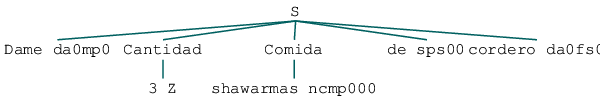

In [147]:
create_trees('Dame 3 shawarmas de cordero', maxent_chunker) 

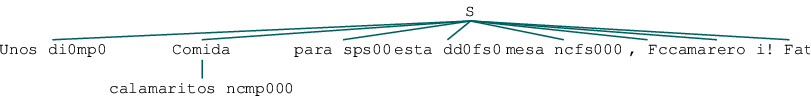

In [133]:
create_trees('Unos calamaritos para esta mesa, camarero!', maxent_chunker) 

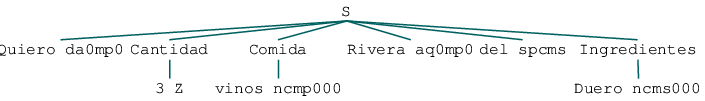

In [126]:
create_trees('Quiero 3 vinos Rivera del Duero', maxent_chunker)

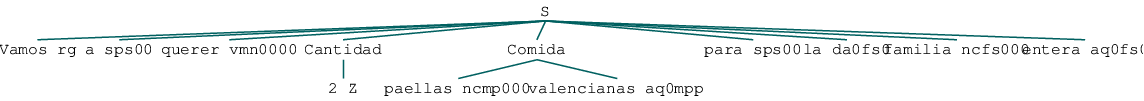

In [128]:
create_trees('Vamos a querer 2 paellas valencianas para la familia entera', maxent_chunker)

In [148]:
# Unamoslos en una cadena con los pedidos:
document4 = 'Dame 3 shawarmas de cordero. Unos calamaritos para esta mesa, camarero! Quiero 3 vinos Rivera del Duero. Vamos a querer 2 paellas valencianas para la familia entera.'

Ahora veamos las etiquetas IOB producidas por este modelo:

In [149]:
process_iob_tags(document4, maxent_chunker)

[[('Dame', 'da0mp0', 'O'),
  ('3', 'Z', 'B-Cantidad'),
  ('shawarmas', 'ncmp000', 'B-Comida'),
  ('de', 'sps00', 'O'),
  ('cordero', 'np0000l', 'B-Ingredientes'),
  ('.', 'Fp', 'O')],
 [('Unos', 'di0mp0', 'O'),
  ('calamaritos', 'ncmp000', 'B-Comida'),
  ('para', 'sps00', 'O'),
  ('esta', 'dd0fs0', 'O'),
  ('mesa', 'ncfs000', 'O'),
  (',', 'Fc', 'O'),
  ('camarero', 'i', 'O'),
  ('!', 'Fat', 'O')],
 [('Quiero', 'da0mp0', 'O'),
  ('3', 'Z', 'B-Cantidad'),
  ('vinos', 'ncmp000', 'B-Comida'),
  ('Rivera', 'aq0mp0', 'O'),
  ('del', 'spcms', 'O'),
  ('Duero', 'ncms000', 'B-Ingredientes'),
  ('.', 'Fp', 'O')],
 [('Vamos', 'rg', 'O'),
  ('a', 'sps00', 'O'),
  ('querer', 'vmn0000', 'O'),
  ('2', 'Z', 'B-Cantidad'),
  ('paellas', 'ncmp000', 'B-Comida'),
  ('valencianas', 'aq0mpp', 'I-Comida'),
  ('para', 'sps00', 'O'),
  ('la', 'da0fs0', 'O'),
  ('familia', 'ncfs000', 'O'),
  ('entera', 'aq0fs0', 'O'),
  ('.', 'Fp', 'O')]]

Ahora procesemos cada uno de los pedidos para obtener los diccionarios con las cantidades, comidas e ingredientes:

In [150]:
process_order(document4, maxent_chunker)

[{'Cantidad': '3', 'Comida': 'shawarmas', 'Ingredientes': 'cordero'},
 {'Comida': 'calamaritos'},
 {'Cantidad': '3', 'Comida': 'vinos', 'Ingredientes': 'Duero'},
 {'Cantidad': '2', 'Comida': 'paellas valencianas'}]

### 4.2 Modelo Clasificador Naive Bayes

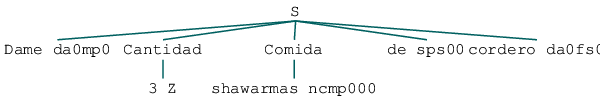

In [146]:
create_trees('Dame 3 shawarmas de cordero', naive_bayes_chunker) 

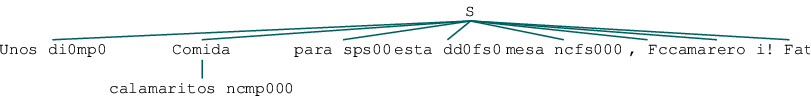

In [141]:
create_trees('Unos calamaritos para esta mesa, camarero!', naive_bayes_chunker) 

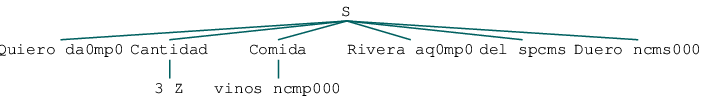

In [142]:
create_trees('Quiero 3 vinos Rivera del Duero', naive_bayes_chunker)

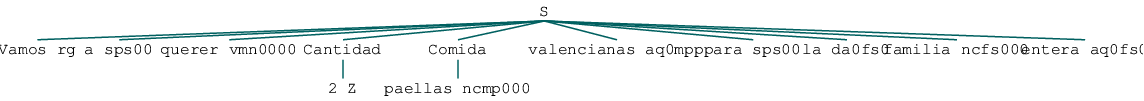

In [143]:
create_trees('Vamos a querer 2 paellas valencianas para la familia entera', naive_bayes_chunker)

In [151]:
process_iob_tags(document4, naive_bayes_chunker)

[[('Dame', 'da0mp0', 'O'),
  ('3', 'Z', 'B-Cantidad'),
  ('shawarmas', 'ncmp000', 'B-Comida'),
  ('de', 'sps00', 'O'),
  ('cordero', 'np0000l', 'B-Ingredientes'),
  ('.', 'Fp', 'O')],
 [('Unos', 'di0mp0', 'O'),
  ('calamaritos', 'ncmp000', 'B-Comida'),
  ('para', 'sps00', 'O'),
  ('esta', 'dd0fs0', 'O'),
  ('mesa', 'ncfs000', 'O'),
  (',', 'Fc', 'O'),
  ('camarero', 'i', 'O'),
  ('!', 'Fat', 'O')],
 [('Quiero', 'da0mp0', 'O'),
  ('3', 'Z', 'B-Cantidad'),
  ('vinos', 'ncmp000', 'B-Comida'),
  ('Rivera', 'aq0mp0', 'O'),
  ('del', 'spcms', 'O'),
  ('Duero', 'ncms000', 'O'),
  ('.', 'Fp', 'O')],
 [('Vamos', 'rg', 'O'),
  ('a', 'sps00', 'O'),
  ('querer', 'vmn0000', 'O'),
  ('2', 'Z', 'B-Cantidad'),
  ('paellas', 'ncmp000', 'B-Comida'),
  ('valencianas', 'aq0mpp', 'O'),
  ('para', 'sps00', 'O'),
  ('la', 'da0fs0', 'O'),
  ('familia', 'ncfs000', 'O'),
  ('entera', 'aq0fs0', 'O'),
  ('.', 'Fp', 'O')]]

In [152]:
process_order(document4, naive_bayes_chunker)

[{'Cantidad': '3', 'Comida': 'shawarmas', 'Ingredientes': 'cordero'},
 {'Comida': 'calamaritos'},
 {'Cantidad': '3', 'Comida': 'vinos'},
 {'Cantidad': '2', 'Comida': 'paellas'}]

### 4.3 Conclusion

Ambos clasificadores han conseguido resultados similares, el modelo clasificador maxent ha sido capaz de etiquetar 'paella valenciana' como un solo concepto de comida, pero tambien ha clasificado mal 'Duero' como ingrediente. 

No ha quedado claro del todo cual de los dos seria mejor para un modelo de produccion, y tambien tenemos que tener en cuenta las grandes limitaciones que tenemos, el CESS corpus no es lo suficientemente grande para entrenar las etiquetas y los corpus de ejemplos usados para el entrenamiento de los modelos tampoco ha sido muy grande, aunque si que podriamos decir que en caso de que tuvieramos que sacar un modelo a produccion este seria o bien un clasificador Mxent o un clasificador Naive Bayes.